In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Standard imports
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import Network as Network
import mnist_loader
import copy
import time

In [3]:
class RobustNetwork(Network.Network):    
    
    def FeedBack(self, y, mode = 'BFA'):
        '''
            y = net.FeedBack(x)

            Runs the network backward, starting with y as input.

        '''
        y = np.array(y)  # Convert input to array, in case it's not
        
        self.lyr[-1].h_feedback = y # Set input layer

        # Loop over connections...
        if (mode == 'BFA'):
            for pre,post,W_feedback in zip(reversed(self.lyr[1:]), reversed(self.lyr[:-1]), reversed(self.W_feedback)):
                post.z_feedback = pre.h_feedback @ W_feedback
                post.h_feedback = post.sigma(post.z_feedback)
                    
        elif(mode == 'BDFA'):
            for post,W_BDFA in zip(reversed(self.lyr[:-1]), reversed(self.W_BDFA)):
                post.z_feedback = y @ W_BDFA
                post.h_feedback = post.sigma(post.z_feedback)
                
        # Return activity of output layer
        return self.lyr[0].h_feedback
    
    def BackProp(self, t, lrate=0.05, mode = 'BP'):
        '''
            net.BackProp(targets, lrate=0.05)
            
            Given the current network state and targets t, updates the connection
            weights and biases using the backpropagation algorithm.
            
            Inputs:
             t      an array of targets (number of samples must match the
                    network's output)
             lrate  learning rate
             decay  is the coefficient for weight/bias decay
        '''
        t = np.array(t)  # convert t to an array, in case it's not
        
        # Error gradient for top layer
        dEdz = self.TopGradient(t)
        top_gradient = dEdz
                
        # Loop down through the layers
        for i in range(self.n_layers-2, -1, -1):
            pre = self.lyr[i]

            # Gradient w.r.t. weights
            dEdW = pre.h.T @ dEdz

            # Project error gradient down to layer below.
            if i>0:
                if(mode == 'BP'):
                    dEdz = (dEdz @ self.W[i].T) * pre.sigma_z_p(pre.z)
                    
                elif(mode == 'FA'):
                    m = self.lyr[i+1].N
                    n = self.lyr[i].N
                    temp = np.random.normal(size=[m,n])/np.sqrt(n)*4.
                    dEdz = (dEdz @ temp) * pre.sigma_z_p(pre.z)
                    
                elif(mode == 'DFA'):
                    m = self.lyr[-1].N
                    n = self.lyr[i].N
                    temp = np.random.normal(size=[m,n])/np.sqrt(n)*4.
                    dEdz = (top_gradient @ temp) * pre.sigma_z_p(pre.z)     
                    
                elif(mode == 'BFA'):
                    dEdz = (dEdz @ self.W_feedback[i]) * pre.sigma_z_p(pre.z)
                    
                elif(mode == 'BDFA'):
                    dEdz = (top_gradient @ self.W_BDFA[i-1]) * pre.sigma_z_p(pre.z)
                    
                          
            # Update weights and biases
            self.W[i] -= lrate*dEdW
            

    def BackProp_FeedBack(self, x, y, lrate = 0.05, mode = 'BFA'):
                
        x = np.array(x)  # convert t to an array, in case it's not
        y = np.array(y)
        
        # Error gradient for top layer
        dEdz_feedback = self.TopGradient(x, mode = 'BFA')

        # Loop down through the layers
        if (mode == 'BFA'):
            for i in range(1,self.n_layers,1):
                pre = self.lyr[i]
                dEdW_feedback = pre.h_feedback.T @ dEdz_feedback

                # Project error gradient down to layer below.
                if i<self.n_layers-1:
                    dEdz_feedback = (dEdz_feedback @ self.W[i-1]) * pre.sigma_z_p(pre.z_feedback)

                self.W_feedback[i-1] -= lrate*dEdW_feedback

        elif(mode =='BDFA'):

#             for i in range(self.n_layers-2):
#                 m = self.lyr[-1].N
#                 n = self.lyr[i+1].N
#                 temp = np.random.normal(size=[m,n])/np.sqrt(n)*4.
#                 self.W_BDFA[i] = temp

            top_gradient_feedback = self.TopGradient(y)
            for i in range(self.n_layers-2):
                pre=self.lyr[i+1]
                dEdW_feedback = top_gradient_feedback.T@pre.h_feedback
                self.W_BDFA[i] -= lrate*dEdW_feedback
            
#                 loss_fn = 1 - Network.Logistic(self.lyr[i+1].z_feedback * self.lyr[i+1].h)
#                 dEdW_BDFA = loss_fn.T @ y
#                 self.W_BDFA[i] -= lrate*dEdW_BDFA.T
      
            
    def SGD(self, inputs, targets, lrate=0.05, epochs=1, batch_size=10, mode='BP'):
        '''
            progress = net.SGD(inputs, targets, lrate=0.05, epochs=1, decay=0, dropout=0)

            Performs Stochastic Gradient Descent on the network.
            Run through the dataset in batches 'epochs' number of times, incrementing the
            network weights after each batch. For each epoch, it
            shuffles the dataset.

            Inputs:
              inputs  is an array of input samples
              targets is a corresponding array of targets
              lrate   is the learning rate (try 0.001 to 5)
              epochs  is the number of times to go through the training data
              decay   is the decay coefficient for the weights and biases
              dropout is the dropout probability
              
            Outputs:
              progress is an (expochs)x2 array with epoch in the first column, and 
                      cost in the second column
        '''

        start = time.time()

        for i in range(self.n_layers-2):
            n = self.lyr[-1].N
            m = self.lyr[i+1].N
            temp = np.random.normal(size=[n,m])/np.sqrt(n)*4.
            self.W_BDFA.append(temp)

        
        loss_history = []
        for k in range(epochs):
            batches = Network.MakeBatches(inputs, targets, batch_size=batch_size, shuffle=True)
            for mini_batch in batches:
                self.FeedForward(mini_batch[0])
                    
                self.BackProp(mini_batch[1], lrate=lrate, mode=mode)

                if (mode in ['BFA', 'BDFA']):
                    self.FeedBack(mini_batch[1], mode=mode)
                    
                if (mode in ['BFA', 'BDFA']):
                    
                    self.BackProp_FeedBack(mini_batch[0], mini_batch[1], lrate=lrate, mode=mode)

            loss_history.append([k, self.Evaluate(inputs, targets)])
            print('Epoch '+str(loss_history[-1][0])+': Cost = '+str(loss_history[-1][1]))

        end = time.time()
        print('Running Time: {}s'.format(end - start))
        return np.array(loss_history)


## Adversarial Input

In [4]:
import random
# Load MNIST
train, validate, test = mnist_loader.load_data_wrapper()
train_in = np.array(train[0])
train_out = np.array(train[1])
test_in = np.array(test[0])
test_out = np.array(test[1])

net_BP = RobustNetwork(cost='categorical-cross-entropy')

net_BP.AddLayer(Network.Layer(784))
net_BP.AddLayer(Network.Layer(400, act='tanh'))
net_BP.AddLayer(Network.Layer(10, act='softmax'))

progress = net_BP.SGD(train_in, train_out, epochs=100, lrate=0.005, batch_size=128, mode='BP')

test_ac = Network.ClassificationAccuracy(net_BP.FeedForward(test[0]), test[1])
print('Testing Accuracy = '+str(test_ac*100)+'%')

train_ac = Network.ClassificationAccuracy(net_BP.FeedForward(train[0]), train[1])
print('Training Accuracy = '+str(train_ac*100)+'%')


Epoch 0: Cost = 0.7853132248277674
Epoch 1: Cost = 0.5664681035047407
Epoch 2: Cost = 0.4817965519097239
Epoch 3: Cost = 0.43396643497455023
Epoch 4: Cost = 0.40260233855905514
Epoch 5: Cost = 0.37914928018025157
Epoch 6: Cost = 0.3607725434847508
Epoch 7: Cost = 0.3456449354618878
Epoch 8: Cost = 0.333098250810057
Epoch 9: Cost = 0.32207700734934036
Epoch 10: Cost = 0.31234809764215055
Epoch 11: Cost = 0.30377101072772184
Epoch 12: Cost = 0.2965074916146072
Epoch 13: Cost = 0.2892056829833439
Epoch 14: Cost = 0.28277981532916097
Epoch 15: Cost = 0.27673827969446213
Epoch 16: Cost = 0.27140928132946557
Epoch 17: Cost = 0.26608051681660083
Epoch 18: Cost = 0.2614552533797989
Epoch 19: Cost = 0.2569236633796788
Epoch 20: Cost = 0.2525958176435306
Epoch 21: Cost = 0.248488075245913
Epoch 22: Cost = 0.24452324434427938
Epoch 23: Cost = 0.24092732785206467
Epoch 24: Cost = 0.23753624055439337
Epoch 25: Cost = 0.23401865972094624
Epoch 26: Cost = 0.2308785278804014
Epoch 27: Cost = 0.2278185

In [5]:
#Extract 10 digits from MNIST classified correctly by the network
x_image = []
x_class = []
ind = []
for i in range(0, 10):
    while True:
        j = random.randint(0, (len(test[0])-1))
        if np.argmax(test[1][j]) == i:
            r = net_BP.FeedForward([test[0][j]])
            if np.argmax(r) == i:
                x_image.append(test[0][j])
                x_class.append(test[1][j])
                ind.append(j)
                break

## Gradient Input

In [6]:
def GradientInput(net, x, t):
    '''
        dEdx = Input_Gradient_Ascent(net, x, t)

        Computes dEdx for a network given input x and target t.
        The cost function is specified by the network.

        Inputs:
          net is the neural network
          x is the input that you want to perturb
          t is the corresponding true target vector (one-hot)
        
        Output:
          dEdx is a vector the same shape as x
    '''

    # ***** YOUR CODE HERE *****
    
    dEdx = copy.deepcopy(x)
    dEdz = net.TopGradient(t)
    for i in range(net.n_layers-2, -1, -1):
        pre = net.lyr[i]
        dEdW = pre.h.T @ dEdz
        if i>0:
            dEdz = ( dEdz @ net.W[i].T ) * pre.sigma_z_p(pre.z)
        else:
            dEdz = ( dEdz @ net.W[i].T ) * pre.sigma_z_p(x)

    dEdx = dEdz
    
    return dEdx

## FGSM

In [7]:
def FGSM(net,x_input, x_class, ep=0.05, it_lim=100000, conf=0.5, targ=False):
    '''
        x_adv = FGSM(x_input, x_class, ep=0.05, it_lim=100000, conf=0.5)
        
        Performs the Fast Gradient Sign Method, perturbing each input until it
        is misclassified with the specified confidence, or reaches the maximum
        number of iterations.
        
        Inputs:
          x_input is a batch of inputs
          x_class is the corresponding one-hot class vectors
          ep is the perturbation step for the FGSM
          it_lim is the maximum number of iterations
          conf is the desired confidence for the misclassification
          targ is Boolean, indicating if the FGSM is targetted
             if targ is False, then x_class is considered to be the true
             class of the input, and FGSM will work to increase the cost
             if targ is True, then x_class is considered to be the target
             class for the perturbation, and FGSM will work to decrease the cost
        
        Output:
          x_adv is a batch of adversarial inputs, the same size as x_input
    '''

    # ***** YOUR CODE HERE *****
    
    x_adv = copy.deepcopy(x_input)
    
    
    if (targ == False):
        x_class = [np.argmax(p) for p in x_class]
        for i in range(len(x_input)): 
            output = Network.OneHot(net.FeedForward([x_input[i]]))
            grad = GradientInput(net,x_input[i], output)
            perturbations = ep * np.sign(grad)
            input_new = x_input[i] + perturbations
            k = 0
                        
            while(k < it_lim):
                res = net.FeedForward(input_new)
                while((np.argmax(res) == x_class[i]) and (k < it_lim)):
                    output = Network.OneHot(res)
                    grad = GradientInput(net,input_new, output)
                    perturbations = ep * np.sign(grad)
                    input_new += perturbations 
                    res = net.FeedForward(input_new)
                
                if (np.max(res) > conf):
                    break
                else:
                    output = Network.OneHot(res)
                    grad = GradientInput(net,input_new, output)
                    perturbations = ep * np.sign(grad)
                    input_new += perturbations
                    
                k += 1 

            x_adv[i] = input_new
            
    else:
        for i in range(len(x_input)): 
            grad = GradientInput(net,x_input[i], x_class[i][0])
            perturbations = ep * np.sign(grad)
            input_new = x_input[i] - perturbations
            k = 0
            it_lim_reduce = it_lim/10
            
            while(k < it_lim_reduce):
                res = net.FeedForward(input_new)
                ans = np.array([np.argmax(p) for p in x_class[i]])
                while(np.argmax(res) not in np.array(ans) and (k < it_lim)):
                    grad = GradientInput(net,input_new, x_class[i][0])
                    perturbations = ep * np.sign(grad)
                    input_new -= perturbations 
                    res = net.FeedForward(input_new)
                    k += 1

                if (np.max(res) > conf):
                    break
                else:
                    grad = GradientInput(net,input_new, x_class[i][0])
                    perturbations = ep * np.sign(grad)
                    input_new += perturbations
                    
                k += 1 
            
            x_adv[i] = input_new
    
    return np.array(x_adv)

In [8]:
time_single = 0
ite = 10
for i in range(ite):
    start = time.time()
    adv_input = FGSM(net_BP,x_image, x_class, conf = 0.5)
    end = time.time()
    time_single += end-start

time_single = time_single/ite
print('time spent: '+str(time_single))

time spent: 0.017450284957885743


digit 0 classified as 2 with classification value 0.5070790008511376
digit 1 classified as 2 with classification value 0.9264079156829872
digit 2 classified as 8 with classification value 0.9872489528844473
digit 3 classified as 8 with classification value 0.9344741332291593
digit 4 classified as 9 with classification value 0.9986075925651822
digit 5 classified as 8 with classification value 0.999770409677894
digit 6 classified as 2 with classification value 0.9898104677760223
digit 7 classified as 9 with classification value 0.9319651799104344
digit 8 classified as 5 with classification value 0.6880262644351485
digit 9 classified as 7 with classification value 0.750243234846677


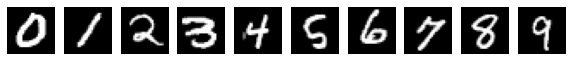

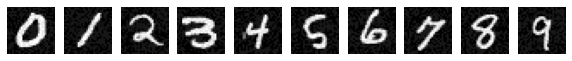

In [9]:
plt.figure(figsize=[10,10])
n_digits = 10
for n in range(n_digits):
    plt.subplot(1,n_digits,n+1)
    plt.imshow(np.reshape(x_image[n], [28,28]), cmap='gray'); plt.axis('off')
    
plt.figure(figsize=[10,10])
for n in range(n_digits):
    plt.subplot(2,n_digits,n+1)
    plt.imshow(np.reshape(adv_input[n], [28,28]), cmap='gray'); plt.axis('off')
    
for i in range(n_digits):
    dig = np.argmax(net_BP.FeedForward(adv_input[i]))
    classification_val = np.max(net_BP.FeedForward(adv_input[i]))
    print('digit '+str(i) + ' classified as '+str(dig)+' with classification value '+str(classification_val))

### using bidirectional model to the adversai linput obtained from single direction model

In [10]:
#train bidirectional model
net_adv = RobustNetwork(cost='categorical-cross-entropy')
net_adv.AddLayer(Network.Layer(784))
net_adv.AddLayer(Network.Layer(400, act='logistic'))
net_adv.AddLayer(Network.Layer(10, act='softmax'))

# Train the network
progress = net_adv.SGD(np.array(train[0]), np.array(train[1]), epochs=30, lrate=0.01, batch_size=128, mode='BFA')

Epoch 0: Cost = 1.5995188834248348
Epoch 1: Cost = 1.1274826719443134
Epoch 2: Cost = 0.897852228025738
Epoch 3: Cost = 0.7683431017701914
Epoch 4: Cost = 0.6868892328088804
Epoch 5: Cost = 0.6303253925104217
Epoch 6: Cost = 0.588893749555639
Epoch 7: Cost = 0.5566297198548381
Epoch 8: Cost = 0.5306904963113871
Epoch 9: Cost = 0.5089310297440455
Epoch 10: Cost = 0.4910103497378435
Epoch 11: Cost = 0.47569664643083054
Epoch 12: Cost = 0.46249878988714493
Epoch 13: Cost = 0.45083659909429036
Epoch 14: Cost = 0.44145981121340944
Epoch 15: Cost = 0.4317403290637615
Epoch 16: Cost = 0.42336119552595286
Epoch 17: Cost = 0.41569603462027305
Epoch 18: Cost = 0.409270977706783
Epoch 19: Cost = 0.4029010784697983
Epoch 20: Cost = 0.3970831614769281
Epoch 21: Cost = 0.39183283513719364
Epoch 22: Cost = 0.3865990510573126
Epoch 23: Cost = 0.3819201271933268
Epoch 24: Cost = 0.3775469368169607
Epoch 25: Cost = 0.3740679465391464
Epoch 26: Cost = 0.36981861760301377
Epoch 27: Cost = 0.36635855866586

In [11]:
time_bfa = 0
ite = 10
for i in range(ite):
    start = time.time()
    adv_input = FGSM(net_adv,x_image, x_class, conf = 0.5)
    end = time.time()
    time_bfa += end-start

time_bfa = time_bfa/ite
print('time spent: '+str(time_bfa))

time spent: 0.02112889289855957


In [12]:
#train bidirectional model
net_adv = RobustNetwork(cost='categorical-cross-entropy')
net_adv.AddLayer(Network.Layer(784))
net_adv.AddLayer(Network.Layer(400, act='logistic'))
net_adv.AddLayer(Network.Layer(10, act='softmax'))

# Train the network
progress = net_adv.SGD(np.array(train[0]), np.array(train[1]), epochs=50, lrate=0.01, batch_size=128, mode='BFA')

time_bfa = 0
ite = 10
for i in range(ite):
    start = time.time()
    adv_input = FGSM(net_adv,x_image, x_class, conf = 0.5)
    end = time.time()
    time_bfa += end-start

time_bfa = time_bfa/ite
print('time spent: '+str(time_bfa))

Epoch 0: Cost = 1.5954434839562162
Epoch 1: Cost = 1.1699443797454374
Epoch 2: Cost = 0.9361809454019426
Epoch 3: Cost = 0.7988112656067875
Epoch 4: Cost = 0.7084319313444124
Epoch 5: Cost = 0.6457048721525681
Epoch 6: Cost = 0.5996692927416553
Epoch 7: Cost = 0.563626440278498
Epoch 8: Cost = 0.5350558920660643
Epoch 9: Cost = 0.5126206999970407
Epoch 10: Cost = 0.4935757885561555
Epoch 11: Cost = 0.4773278226304356
Epoch 12: Cost = 0.4634090219827853
Epoch 13: Cost = 0.45189111799986575
Epoch 14: Cost = 0.44121507406575794
Epoch 15: Cost = 0.43184483945955404
Epoch 16: Cost = 0.42352076012248885
Epoch 17: Cost = 0.4162345628771741
Epoch 18: Cost = 0.40953502710911033
Epoch 19: Cost = 0.40323532716229
Epoch 20: Cost = 0.397538053946709
Epoch 21: Cost = 0.392037385263964
Epoch 22: Cost = 0.3872298974924763
Epoch 23: Cost = 0.38268207524264153
Epoch 24: Cost = 0.37813725219994465
Epoch 25: Cost = 0.3745548628698492
Epoch 26: Cost = 0.3703769843608528
Epoch 27: Cost = 0.3669028413807057


In [13]:
#train bidirectional model
net_adv = RobustNetwork(cost='categorical-cross-entropy')
net_adv.AddLayer(Network.Layer(784))
net_adv.AddLayer(Network.Layer(400, act='logistic'))
net_adv.AddLayer(Network.Layer(10, act='softmax'))

# Train the network
progress = net_adv.SGD(np.array(train[0]), np.array(train[1]), epochs=100, lrate=0.01, batch_size=128, mode='BFA')

time_bfa = 0
ite = 10
for i in range(ite):
    start = time.time()
    adv_input = FGSM(net_adv,x_image, x_class, conf = 0.5)
    end = time.time()
    time_bfa += end-start

time_bfa = time_bfa/ite
print('time spent: '+str(time_bfa))

Epoch 0: Cost = 1.612654955958254
Epoch 1: Cost = 1.1563256295251596
Epoch 2: Cost = 0.9178441642411215
Epoch 3: Cost = 0.7818184447494256
Epoch 4: Cost = 0.6941315865966065
Epoch 5: Cost = 0.6336677104831138
Epoch 6: Cost = 0.58935232887677
Epoch 7: Cost = 0.5550237188041233
Epoch 8: Cost = 0.5278716236144675
Epoch 9: Cost = 0.5058079098827326
Epoch 10: Cost = 0.4873881477825968
Epoch 11: Cost = 0.47203808253264673
Epoch 12: Cost = 0.4581111533693381
Epoch 13: Cost = 0.44660873268577866
Epoch 14: Cost = 0.4361965936316097
Epoch 15: Cost = 0.42724031781324445
Epoch 16: Cost = 0.4188678929577301
Epoch 17: Cost = 0.4117145723466419
Epoch 18: Cost = 0.40517895164388695
Epoch 19: Cost = 0.39932059989480595
Epoch 20: Cost = 0.39378330211202617
Epoch 21: Cost = 0.38846575542543127
Epoch 22: Cost = 0.38371937210966206
Epoch 23: Cost = 0.37937407457579875
Epoch 24: Cost = 0.3752781663334804
Epoch 25: Cost = 0.37154008841134406
Epoch 26: Cost = 0.36771588710811004
Epoch 27: Cost = 0.36457930301

### BDFA on Adversarial

In [14]:
net_adv2 = RobustNetwork(cost='categorical-cross-entropy')
net_adv2.AddLayer(Network.Layer(784))
net_adv2.AddLayer(Network.Layer(400, act='logistic'))
net_adv2.AddLayer(Network.Layer(10, act='softmax'))

# Train the network
progress = net_adv2.SGD(np.array(train[0]), np.array(train[1]), epochs=30, lrate=0.01, batch_size=128, mode='BDFA')

Epoch 0: Cost = 1.1604573291792817
Epoch 1: Cost = 0.6965171587855389
Epoch 2: Cost = 0.5515314879348936
Epoch 3: Cost = 0.4792864475040201
Epoch 4: Cost = 0.437875070627269
Epoch 5: Cost = 0.4092902406449347
Epoch 6: Cost = 0.38712377753084426
Epoch 7: Cost = 0.37044363013056675
Epoch 8: Cost = 0.3565648821728953
Epoch 9: Cost = 0.3446005439251157
Epoch 10: Cost = 0.33464655858777753
Epoch 11: Cost = 0.32620857861617913
Epoch 12: Cost = 0.3177516501072227
Epoch 13: Cost = 0.3100055516375955
Epoch 14: Cost = 0.3035009434096881
Epoch 15: Cost = 0.2970472511463706
Epoch 16: Cost = 0.29102390805014283
Epoch 17: Cost = 0.28581645430273284
Epoch 18: Cost = 0.280815158575108
Epoch 19: Cost = 0.27604948169413007
Epoch 20: Cost = 0.2710810765056635
Epoch 21: Cost = 0.26646307129564245
Epoch 22: Cost = 0.26229310529199057
Epoch 23: Cost = 0.2582716825911988
Epoch 24: Cost = 0.2543435838959703
Epoch 25: Cost = 0.25062569949407776
Epoch 26: Cost = 0.24678874862438774
Epoch 27: Cost = 0.2435412120

In [15]:
time_bdfa = 0
ite = 10
for i in range(ite):
    start = time.time()
    adv_input = FGSM(net_adv2,x_image, x_class, conf = 0.5)
    end = time.time()
    time_bdfa += end-start

time_bdfa = time_bdfa/ite
print('time spent: '+str(time_bfa))

time spent: 0.019567060470581054


In [16]:
net_adv2 = RobustNetwork(cost='categorical-cross-entropy')
net_adv2.AddLayer(Network.Layer(784))
net_adv2.AddLayer(Network.Layer(400, act='logistic'))
net_adv2.AddLayer(Network.Layer(10, act='softmax'))

# Train the network
progress = net_adv2.SGD(np.array(train[0]), np.array(train[1]), epochs=50, lrate=0.01, batch_size=128, mode='BDFA')

Epoch 0: Cost = 1.1554032611224818
Epoch 1: Cost = 0.6970294228398242
Epoch 2: Cost = 0.5504788248534767
Epoch 3: Cost = 0.4804006446871226
Epoch 4: Cost = 0.4383330839882226
Epoch 5: Cost = 0.40914870282970406
Epoch 6: Cost = 0.3876170147851442
Epoch 7: Cost = 0.3709113808900585
Epoch 8: Cost = 0.3570392218361528
Epoch 9: Cost = 0.3450183649603466
Epoch 10: Cost = 0.33493791713909726
Epoch 11: Cost = 0.3253895887414348
Epoch 12: Cost = 0.3177827042606966
Epoch 13: Cost = 0.30986799159837697
Epoch 14: Cost = 0.3027909658191925
Epoch 15: Cost = 0.29697557915354733
Epoch 16: Cost = 0.29065625376003373
Epoch 17: Cost = 0.28534586549759666
Epoch 18: Cost = 0.28032871294905953
Epoch 19: Cost = 0.27480536377111375
Epoch 20: Cost = 0.27032736009008346
Epoch 21: Cost = 0.26652274197229747
Epoch 22: Cost = 0.2616436101303462
Epoch 23: Cost = 0.2575977813941316
Epoch 24: Cost = 0.25418723592010034
Epoch 25: Cost = 0.2498072292491558
Epoch 26: Cost = 0.2463029297124875
Epoch 27: Cost = 0.24244902

In [17]:
time_bdfa = 0
ite = 10
for i in range(ite):
    start = time.time()
    adv_input = FGSM(net_adv2,x_image, x_class, conf = 0.5)
    end = time.time()
    time_bdfa += end-start

time_bdfa = time_bdfa/ite
print('time spent: '+str(time_bfa))

time spent: 0.019567060470581054


digit 0 classified as 5 with classification value 0.9447764512935559
digit 1 classified as 2 with classification value 0.5388419473253572
digit 2 classified as 8 with classification value 0.984069807451503
digit 3 classified as 2 with classification value 0.8266174933174605
digit 4 classified as 9 with classification value 0.9972190352670993
digit 5 classified as 8 with classification value 0.8882645283923053
digit 6 classified as 2 with classification value 0.9863259003275586
digit 7 classified as 9 with classification value 0.9347220914234408
digit 8 classified as 5 with classification value 0.6170675102596107
digit 9 classified as 4 with classification value 0.9419841029800037


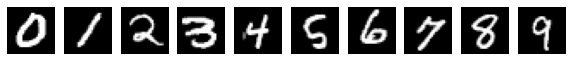

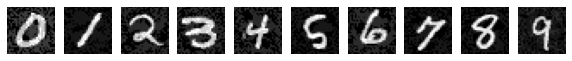

In [18]:
plt.figure(figsize=[10,10])
n_digits = 10
for n in range(n_digits):
    plt.subplot(1,n_digits,n+1)
    plt.imshow(np.reshape(x_image[n], [28,28]), cmap='gray'); plt.axis('off')
    
plt.figure(figsize=[10,10])
for n in range(n_digits):
    plt.subplot(2,n_digits,n+1)
    plt.imshow(np.reshape(adv_input[n], [28,28]), cmap='gray'); plt.axis('off')
    
for i in range(n_digits):
    dig = np.argmax(net_adv2.FeedForward(adv_input[i]))
    classification_val = np.max(net_adv2.FeedForward(adv_input[i]))
    print('digit '+str(i) + ' classified as '+str(dig)+' with classification value '+str(classification_val))

## Targeted adversarial

In [19]:
x_image2 = np.array([x_image[i] for i in [5,1,7]])
# x_image2 = copy_digits
x_class2 = np.array([[x_class[3],x_class[9]], [x_class[0],x_class[2],x_class[8]],[x_class[6],x_class[4]]])

/opt/conda/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
#train bidirectional model
net_adv = RobustNetwork(cost='categorical-cross-entropy')
net_adv.AddLayer(Network.Layer(784))
net_adv.AddLayer(Network.Layer(400, act='logistic'))
net_adv.AddLayer(Network.Layer(400, act='logistic'))
net_adv.AddLayer(Network.Layer(10, act='softmax'))

# Train the network
progress = net_adv.SGD(np.array(train[0]), np.array(train[1]), epochs=50, lrate=0.01, batch_size=128, mode='BFA')

Epoch 0: Cost = 2.047364456816426
Epoch 1: Cost = 1.6198257533044569
Epoch 2: Cost = 1.278780927269682
Epoch 3: Cost = 1.0539156133700378
Epoch 4: Cost = 0.9074610588955163
Epoch 5: Cost = 0.8064679252412857
Epoch 6: Cost = 0.7345183631957866
Epoch 7: Cost = 0.6803098596244789
Epoch 8: Cost = 0.6371551078780651
Epoch 9: Cost = 0.6026912487242505
Epoch 10: Cost = 0.5754447753087928
Epoch 11: Cost = 0.5513905523630238
Epoch 12: Cost = 0.531282053920113
Epoch 13: Cost = 0.5146870104268383
Epoch 14: Cost = 0.5007393988380567
Epoch 15: Cost = 0.4871550880872437
Epoch 16: Cost = 0.47532267892008223
Epoch 17: Cost = 0.46612594450338685
Epoch 18: Cost = 0.45663860353532953
Epoch 19: Cost = 0.44773993272642365
Epoch 20: Cost = 0.4404480732738953
Epoch 21: Cost = 0.4331863990354575
Epoch 22: Cost = 0.4267548810894275
Epoch 23: Cost = 0.4208925102653621
Epoch 24: Cost = 0.4156199191422062
Epoch 25: Cost = 0.4101412777379257
Epoch 26: Cost = 0.40558990348513696
Epoch 27: Cost = 0.4013182959688029


In [21]:
time_bfa = 0
ite = 10
for i in range(ite):
    start = time.time()
    adv_input = FGSM(net_adv,x_image2, x_class2, conf = 0.8, targ = True)
    end = time.time()
    time_bfa += end-start

time_bfa = time_bfa/ite
# print('time spent: '+str(time_bfa))

In [22]:
#train bidirectional model
net_fa1 = RobustNetwork(cost='categorical-cross-entropy')
net_fa1.AddLayer(Network.Layer(784))
net_fa1.AddLayer(Network.Layer(400, act='logistic'))
net_fa1.AddLayer(Network.Layer(400, act='logistic'))
net_fa1.AddLayer(Network.Layer(10, act='softmax'))

progress = net_fa1.SGD(np.array(train[0]), np.array(train[1]), epochs=50, lrate=0.01, batch_size=128, mode='FA')


Epoch 0: Cost = 1.9770895653603915
Epoch 1: Cost = 1.6908006721537796
Epoch 2: Cost = 1.4863666023850006
Epoch 3: Cost = 1.3367116634762664
Epoch 4: Cost = 1.2225043541582883
Epoch 5: Cost = 1.1309543612950157
Epoch 6: Cost = 1.0581546087636808
Epoch 7: Cost = 1.0000679212904353
Epoch 8: Cost = 0.9513447619296782
Epoch 9: Cost = 0.9094581918982313
Epoch 10: Cost = 0.8752014427263983
Epoch 11: Cost = 0.8440785617376643
Epoch 12: Cost = 0.8175170129114011
Epoch 13: Cost = 0.7935994047780526
Epoch 14: Cost = 0.7738398738801827
Epoch 15: Cost = 0.7549935555524756
Epoch 16: Cost = 0.7375524145206724
Epoch 17: Cost = 0.7220123452248656
Epoch 18: Cost = 0.7075715052887661
Epoch 19: Cost = 0.6951057056409203
Epoch 20: Cost = 0.6836666500859588
Epoch 21: Cost = 0.6725239819871786
Epoch 22: Cost = 0.6622988331992643
Epoch 23: Cost = 0.6536382340679928
Epoch 24: Cost = 0.644846459697576
Epoch 25: Cost = 0.6364918900552597
Epoch 26: Cost = 0.6290153290126528
Epoch 27: Cost = 0.6223045112770621
Epo

In [23]:
time_bfa = 0
ite = 10
for i in range(ite):
    start = time.time()
    adv_input = FGSM(net_fa1,x_image2, x_class2, conf = 0.8, targ = True)
    end = time.time()
    time_bfa += end-start

time_bfa = time_bfa/ite
# print('time spent: '+str(time_bfa))